## Import all the functions

In [250]:
import numpy as np
import cv2 as cv
import matplotlib as mt
from matplotlib import pyplot as plt
import pydicom as dicom
print("OpenCV Version: " + cv.__version__)
print("Numpy version: " + np.__version__)
print("Matplotlib version: " + mt.__version__)
print("Pydicom Version: " + dicom.__version__)


OpenCV Version: 4.5.5
Numpy version: 1.22.2
Matplotlib version: 3.5.1
Pydicom Version: 2.2.2


## Utility Functions

In [251]:
def show(img: np.ndarray, title:str, cmap:str):
    plt.figure(figsize = (7,7))
    plt.title(title)
    plt.imshow(img,cmap=cmap)
    plt.show()

def GetExtension(path:str):
    extension = path[-4::]

    if( extension in ['.dcm'] ):
        return True
    else:
        return False


## Dictionary to control easily the images

In [252]:
imagesDictionary = {
                    1 : 'Assets/dcm/Bmass_Test_1.dcm',
                    2 : 'Assets/dcm/Bmass_Test_2.dcm',
                    3 : "Assets/dcm/Bmass_Test_3.dcm",
                    4 : "Assets/dcm/Bmass_Test_4.dcm",
                    5 : "Assets/dcm/Bmass_Test_5.dcm",
                    6 : "Assets/dcm/Bmass_Test_6.dcm",
                    7 : "Assets/dcm/Bmass_Test_7.dcm",
                    8 : "Assets/dcm/Bmass_Test_8.dcm",
                    9 : "Assets/dcm/Bmass_Test_9.dcm",
                    10 : "Assets/dcm/Bmass_Test_10.dcm",
                    11 : "Assets/dcm/Bmass_Test_11.dcm",
                    12 : "Assets/dcm/Bmass_Test_12.dcm",
                    13 :"Assets/dcm/Bmass_Test_13.dcm"
                   }

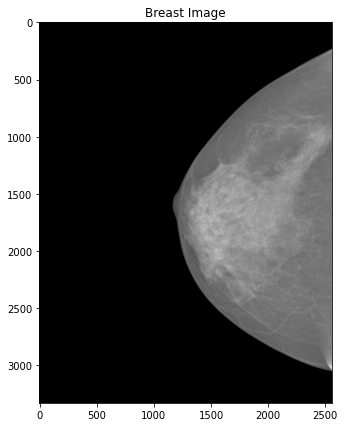

In [253]:
image_path = imagesDictionary.get(4)

if(GetExtension(image_path)):
    bMass_dcm =  dicom.dcmread(image_path)
    bMass = bMass_dcm.pixel_array
else:
    bMass = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

show(bMass, "Breast Image",'gray')

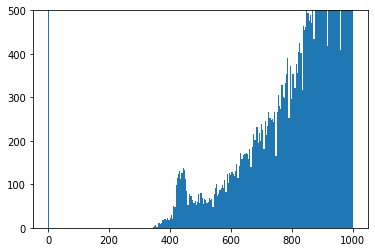

In [254]:
plt.hist(bMass.ravel(), 256, (0, 1000))
plt.ylim(0,500)

plt.show()

## Blur Breast Image

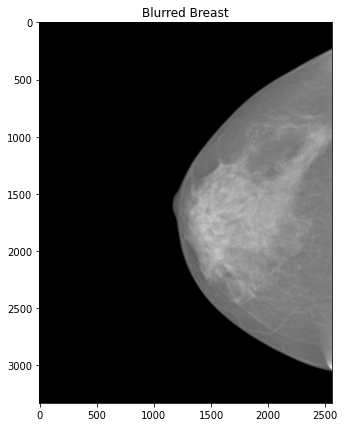

In [255]:
blur = cv.GaussianBlur(bMass, (25,25), 0)
show(blur, "Blurred Breast", 'gray')

## Threshold with OTSU 

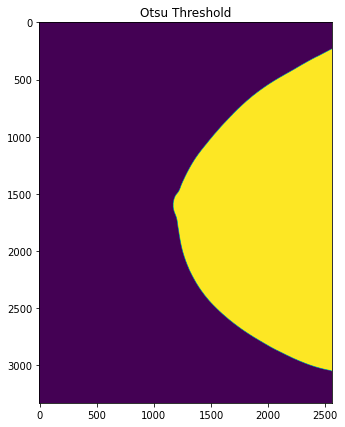

In [256]:
ret, breast_mask = cv.threshold(blur, 0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)
show(breast_mask, "Otsu Threshold", None)

## Find Contours with OpenCV

In [257]:
ret

714.0

In [258]:
cnts, _ = cv.findContours(breast_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnt = max(cnts, key = cv.contourArea)
x,y,w,h = cv.boundingRect(cnt)
breast_mask = breast_mask[y:y+h, x:x+w]
bMass = bMass[y:y+h, x:x+w]

len(cnts)

1

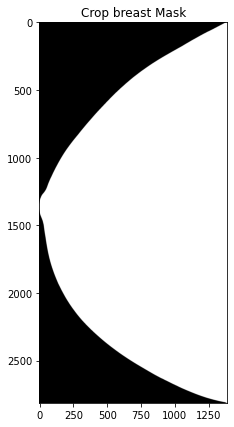

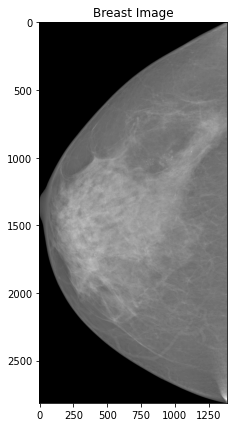

In [259]:
show(breast_mask, "Crop breast Mask", 'gray')
show(bMass, "Breast Image",'gray')

## Truncation Normalization

In [260]:
Pmin = np.percentile(bMass[breast_mask != 0], 5)
Pmax = np.percentile(bMass[breast_mask != 0], 99)

(Pmin, Pmax)

(1126.0, 1966.0)

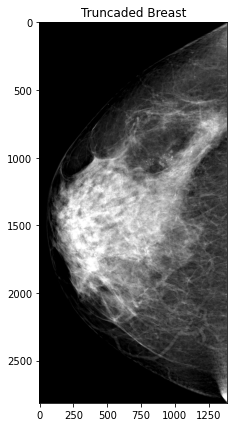

In [261]:
truncated = np.clip(bMass, Pmin, Pmax)

show(truncated, "Truncaded Breast", 'gray')

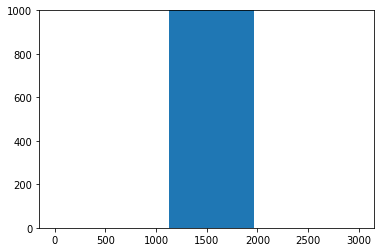

In [262]:
plt.hist(truncated.ravel(), 256, (0, 3000))
plt.ylim(0,1000)
plt.show()

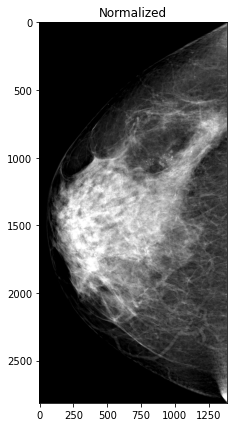

In [263]:
normalized = (truncated - Pmin)/(Pmax - Pmin)

normalized[breast_mask == 0] = 0

show(normalized, "Normalized", 'gray')

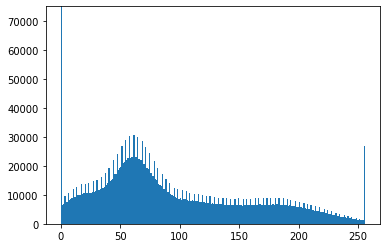

In [264]:
plt.hist(normalized.ravel() * 255, 256, (0, 256))
plt.ylim(0, 75000)
plt.show()

## Ecualizacion Adaptativa del Histograma

In [265]:
clahe = cv.createCLAHE(clipLimit = 1)
cl0 = clahe.apply(np.array(normalized*255, dtype = np.uint8))

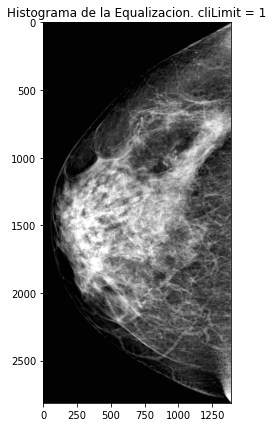

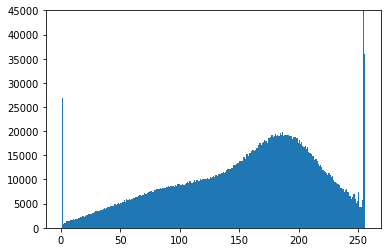

In [266]:
show(cl0, "Histograma de la Equalizacion. cliLimit = 1", 'gray')


plt.hist(cl0.ravel() * 255, 256, (0, 256))
plt.ylim(0, 45000)
plt.show()

In [267]:
clahe = cv.createCLAHE(clipLimit = 2)
cl1 = clahe.apply(np.array(normalized*255, dtype = np.uint8))

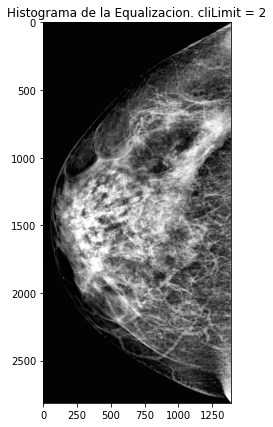

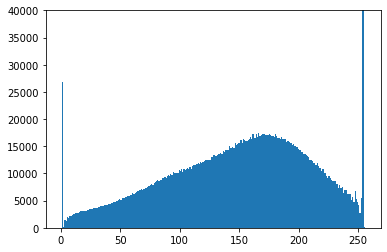

In [268]:
show(cl1, "Histograma de la Equalizacion. cliLimit = 2", 'gray')
plt.hist(cl1.ravel() * 255, 256, (0, 256))
plt.ylim(0, 40000)
plt.show()

In [269]:
synthetized = cv.merge((np.array(normalized*255, dtype=np.uint8),cl0,cl1))

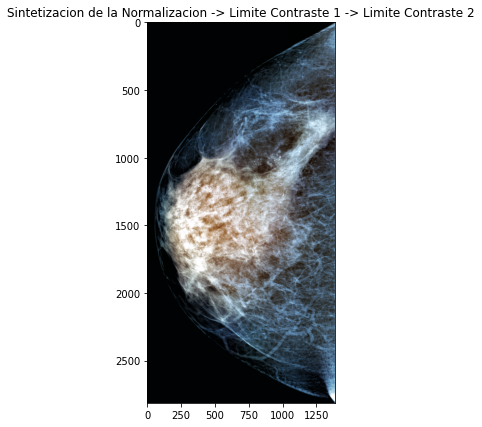

In [270]:
plt.figure(figsize = (7,7))
plt.title("Sintetizacion de la Normalizacion -> Limite Contraste 1 -> Limite Contraste 2")
plt.imshow(synthetized)
plt.show()

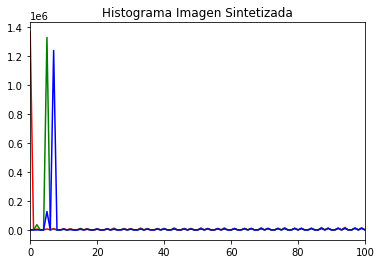

In [271]:
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv.calcHist([synthetized],[i],None,[256],[0,100])
    plt.plot(histr,color = col)
    plt.xlim([0,100])
plt.title("Histograma Imagen Sintetizada")
plt.show()